### Predicing the students G3 results using the attributes using PCA

In [19]:
import pandas as pd
import requests
import os
import numpy as np

In [20]:
url='https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip'
response =requests.get(url)

In [21]:
with open('data_file.zip', 'wb') as fp:
    fp.write(response.content)

In [22]:
import zipfile36 as zipfile
DATA_FILE_ZIP='data_file.zip'
os.makedirs('data',exist_ok=True)
DATA_FOLDER ='./data/'

In [23]:
z = zipfile.ZipFile(DATA_FILE_ZIP)
z.extractall(path=DATA_FOLDER)

In [24]:
df=pd.read_csv(f'{DATA_FOLDER}/student-mat.csv', delimiter=';')

## Add category columns

In [25]:
# Add category column
from sklearn.preprocessing import LabelEncoder
raw_values  = df['G3'].to_list()
cat_values = [2 if r > 15 else 1 if r > 7 else 0  for r in raw_values]
df = df.drop(columns=['G3'])

## Encode all the String data

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

### Label encoding and Standardizing

In [27]:
text_columns= []
num_columns = []
for col in df.columns:
    if 'int64' == df[col].dtype:
        num_columns.append(col)
    else:
        text_columns.append(col)
        
encoder_dict = {c: LabelEncoder().fit(df[c]) for c in text_columns}
transformed_df = pd.DataFrame()
for col in df.columns:
    if col in text_columns:
        transformed_df[col] = encoder_dict.get(col).transform(df[col])
    else:
        transformed_df[col] = df[col]

## standardize
std_df = pd.DataFrame()
std_scalar_dict = {col: StandardScaler().fit_transform(transformed_df[col].to_numpy().reshape(-1,1)) for col in df.columns}
for col in df.columns:
    std_df[col] = std_scalar_dict.get(col).reshape(-1,)

## Visualize

In [28]:
import seaborn as snb
import matplotlib.pyplot as plt

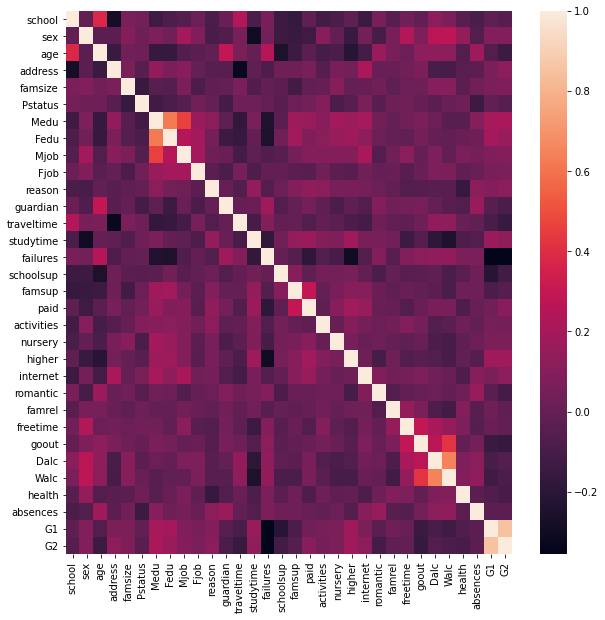

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
snb.heatmap(std_df.corr(), ax=ax)

## Analyse outliers

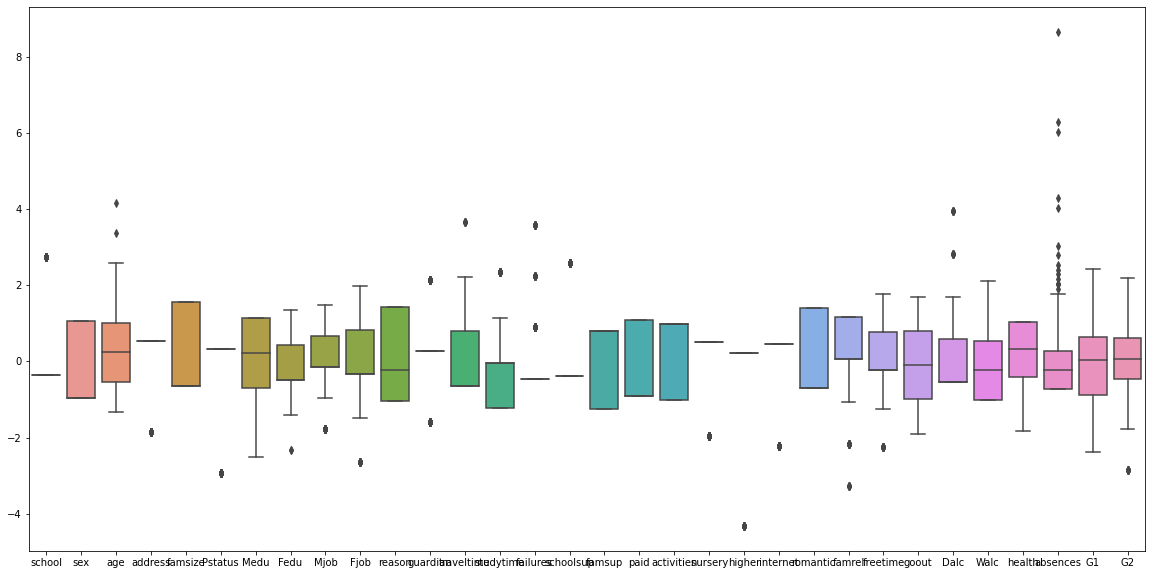

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
snb.boxplot(data=std_df, ax=ax)

## Use PCA

In [31]:
from sklearn.decomposition import PCA

In [32]:
pca = PCA(n_components=10)
pc = pca.fit_transform(std_df)
pca_names = ['components-'+str(i) for i in range(10)]
pca_df = pd.DataFrame(pc, columns=pca_names)

## Add the category column

In [33]:
pca_df['y'] = cat_values

## Shuffle the rows and split train and test

In [34]:
shuffled_df = pca_df.sample(frac=1, replace=False, random_state=42)
train_split_ratio = int(0.8 * len(shuffled_df))
train_df = shuffled_df[:train_split_ratio]
test_df = shuffled_df[train_split_ratio:]
y = train_df['y']
y_test = test_df['y']
cols = train_df.columns.to_list()
for col in ['y']:
     cols.remove(col)
X = train_df[cols]
X_test= test_df[cols]

In [35]:
pca_df.groupby(by='y').count()

,components-0,components-1,components-2,components-3,components-4,components-5,components-6,components-7,components-8,components-9
y,,,,,,,,,,
0,70,70,70,70,70,70,70,70,70,70
1,285,285,285,285,285,285,285,285,285,285
2,40,40,40,40,40,40,40,40,40,40


### Use Random Forest Classifier

### Hyper parameters for Random forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate
rf = RandomForestClassifier(random_state=42)
param_dist = {
    'max_depth':[ int(x) for x in  np.linspace(2, 5)],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    'n_estimators':[int(x) for x in np.linspace(50, 150)]
}

In [37]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,n_iter=100, cv=5, verbose=1, random_state=42, n_jobs=-1 )
rf_random.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.3s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [50, 52, 54, 56, 58, 60,
                                                         62, 64, 66, 68, 70, 72,
                                                         74, 76, 78, 80, 82, 84,
                                                         86, 88, 90, 92, 94, 96,
                                                         98, 101, 103, 105, 107,
                                                         109, ...]},
                   random_state=42, verbose=1)

### Evaluate performance

In [38]:
def evaluate(y_true, y_pred):
    from sklearn.metrics import classification_report
    return classification_report(y_true, y_pred)

In [39]:
clf = rf_random.best_estimator_
y_pred = clf.predict(X_test)
report = evaluate(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.62      0.45      0.53        11
           1       0.84      0.92      0.88        63
           2       0.00      0.00      0.00         5

    accuracy                           0.80        79
   macro avg       0.49      0.46      0.47        79
weighted avg       0.76      0.80      0.77        79



### Plot ROC AUC Curve

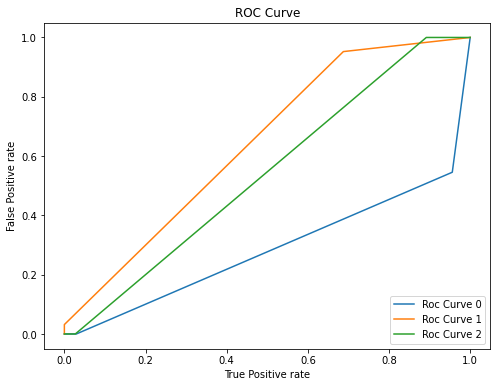

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve
label_names=[0,1,2]

fpr= {}
tpr={}
plt.figure(figsize=(8,6))
for label in label_names:
    fpr[label], tpr[label], _ = roc_curve(y_test, y_pred, pos_label=[label])
    plt.plot(fpr[label],tpr[label], label=f'Roc Curve {label}', )
    plt.xlabel("True Positive rate")
    plt.ylabel("False Positive rate")
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

In [41]:
from sklearn.preprocessing import LabelBinarizer
y_true = LabelBinarizer().fit_transform(y_test)
y_pred = LabelBinarizer().fit_transform(y_pred)
scores=[]
for label in range(3):
    s = roc_auc_score(y_true[:,label], y_pred[:, label])
    print(f' Label {str(label)} - {str(s)}')
    scores.append(s)

 Label 0 - 0.7052139037433155
 Label 1 - 0.6165674603174602
 Label 2 - 0.4864864864864865


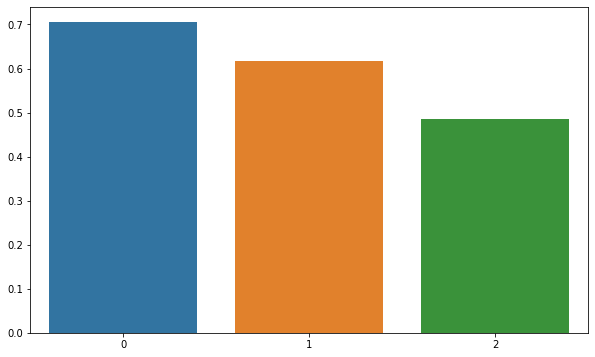

In [42]:
plt.figure(figsize=(10,6))

snb.barplot(x=[0,1,2], y=scores)